# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from tqdm import tqdm

In [2]:
import kagglehub
import os

# Download the dataset and get the path to the directory
path = kagglehub.dataset_download("alanvourch/tmdb-movies-daily-updates")

# List all files in the directory to find the CSV file
files = os.listdir(path)
print("Files in dataset:", files)

csv_file = next((f for f in files if "movies" in f and f.endswith(".csv")), None)

if csv_file:
    full_path = os.path.join(path, csv_file)
    df = pd.read_csv(full_path)
    print("Data preview:")
    print(df.head())
else:
    print("CSV file not found in the downloaded dataset.")


Files in dataset: ['TMDB_all_movies.csv']
Data preview:
   id                             title  vote_average  vote_count    status  \
0   2                             Ariel           7.1       335.0  Released   
1   3               Shadows in Paradise           7.3       369.0  Released   
2   5                        Four Rooms           5.8      2623.0  Released   
3   6                    Judgment Night           6.5       331.0  Released   
4   8  Life in Loops (A Megacities RMX)           7.5        27.0  Released   

  release_date     revenue  runtime      budget    imdb_id  ...  \
0   1988-10-21         0.0     73.0         0.0  tt0094675  ...   
1   1986-10-17         0.0     74.0         0.0  tt0092149  ...   
2   1995-12-09   4257354.0     98.0   4000000.0  tt0113101  ...   
3   1993-10-15  12136938.0    109.0  21000000.0  tt0107286  ...   
4   2006-01-01         0.0     80.0     42000.0  tt0825671  ...   

                         spoken_languages  \
0                    

In [3]:
print(f'Shape of the dataset: {df.shape}')

Shape of the dataset: (1016527, 28)


In [4]:
print(f'Dataset info:')
print(df.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016527 entries, 0 to 1016526
Data columns (total 28 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1016527 non-null  int64  
 1   title                    1016516 non-null  object 
 2   vote_average             1016525 non-null  float64
 3   vote_count               1016525 non-null  float64
 4   status                   1016525 non-null  object 
 5   release_date             903854 non-null   object 
 6   revenue                  1016525 non-null  float64
 7   runtime                  1016525 non-null  float64
 8   budget                   1016525 non-null  float64
 9   imdb_id                  590237 non-null   object 
 10  original_language        1016525 non-null  object 
 11  original_title           1016516 non-null  object 
 12  overview                 837498 non-null   object 
 13  popularity               101

### There are several columns that are not meaningful for our analysis:

1. **id** and **imdb_id** contain only identifiers
2. **overview** has summary of the movie's plot which is long text data
3. **poster_path** has link to movie's poster



In [5]:
df = df.drop(columns=['id', 'imdb_id', 'overview', 'poster_path'])

In [6]:
print(f'Shape of the dataset after dropping: {df.shape}')

Shape of the dataset after dropping: (1016527, 24)


In [7]:
print('Number of missing values:')
print(df.isnull().sum())

Number of missing values:
title                          11
vote_average                    2
vote_count                      2
status                          2
release_date               112673
revenue                         2
runtime                         2
budget                          2
original_language               2
original_title                 11
popularity                      2
tagline                    865742
genres                     295090
production_companies       547520
production_countries       401524
spoken_languages           390357
cast                       338096
director                   183483
director_of_photography    772707
writers                    524280
producers                  693248
music_composer             917336
imdb_rating                587455
imdb_votes                 587455
dtype: int64


### We will drop the rows with missing **imdb_rating**, which is our target for this project

In [8]:
rows_before = df.shape[0]
df = df.dropna(subset=['imdb_rating'])
rows_after = df.shape[0]
print(f'Shape of the data after removing NA: {df.shape}')
print(f'Number of rows dropped: {rows_before - rows_after}')

Shape of the data after removing NA: (429072, 24)
Number of rows dropped: 587455


In [9]:
print('Number of missing values:')
print(df.isnull().sum())

Number of missing values:
title                           0
vote_average                    0
vote_count                      0
status                          0
release_date                 8193
revenue                         0
runtime                         0
budget                          0
original_language               0
original_title                  0
popularity                      0
tagline                    336490
genres                      54172
production_companies       155080
production_countries        95716
spoken_languages            93357
cast                        63282
director                    26974
director_of_photography    267825
writers                    130207
producers                  226939
music_composer             345768
imdb_rating                     0
imdb_votes                      0
dtype: int64


### We will also remove the rows with missing release_date since it only contains a small portion of data.

In [10]:
df = df.dropna(subset=['release_date'])
print(f'Shape of the data after removing NA: {df.shape}')

Shape of the data after removing NA: (420879, 24)


In [11]:
print(f'Dataset info:')
print(df.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 420879 entries, 0 to 1016443
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   title                    420879 non-null  object 
 1   vote_average             420879 non-null  float64
 2   vote_count               420879 non-null  float64
 3   status                   420879 non-null  object 
 4   release_date             420879 non-null  object 
 5   revenue                  420879 non-null  float64
 6   runtime                  420879 non-null  float64
 7   budget                   420879 non-null  float64
 8   original_language        420879 non-null  object 
 9   original_title           420879 non-null  object 
 10  popularity               420879 non-null  float64
 11  tagline                  91347 non-null   object 
 12  genres                   372522 non-null  object 
 13  production_companies     273215 non-null  object 

## Target column

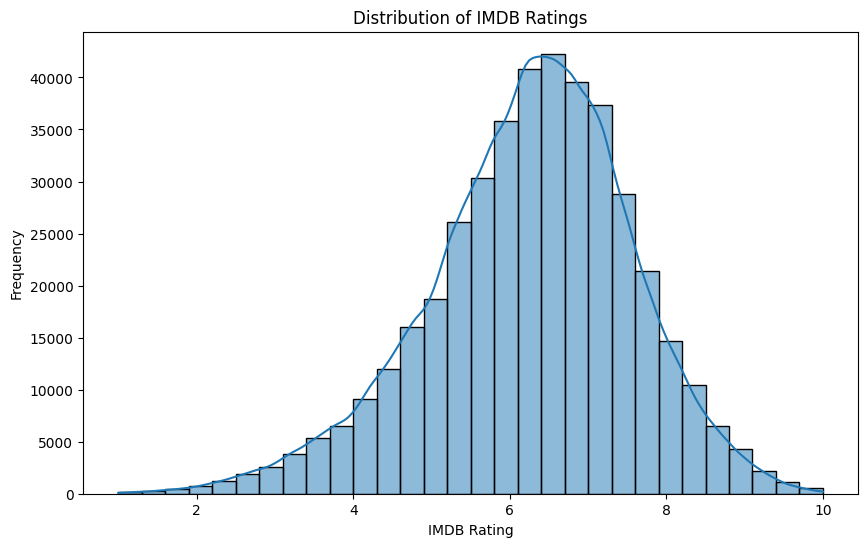

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df['imdb_rating'], bins=30, kde=True)
plt.title('Distribution of IMDB Ratings')
plt.xlabel('IMDB Rating')
plt.ylabel('Frequency')
plt.show()

## Input variables
### vote_count & vote_average

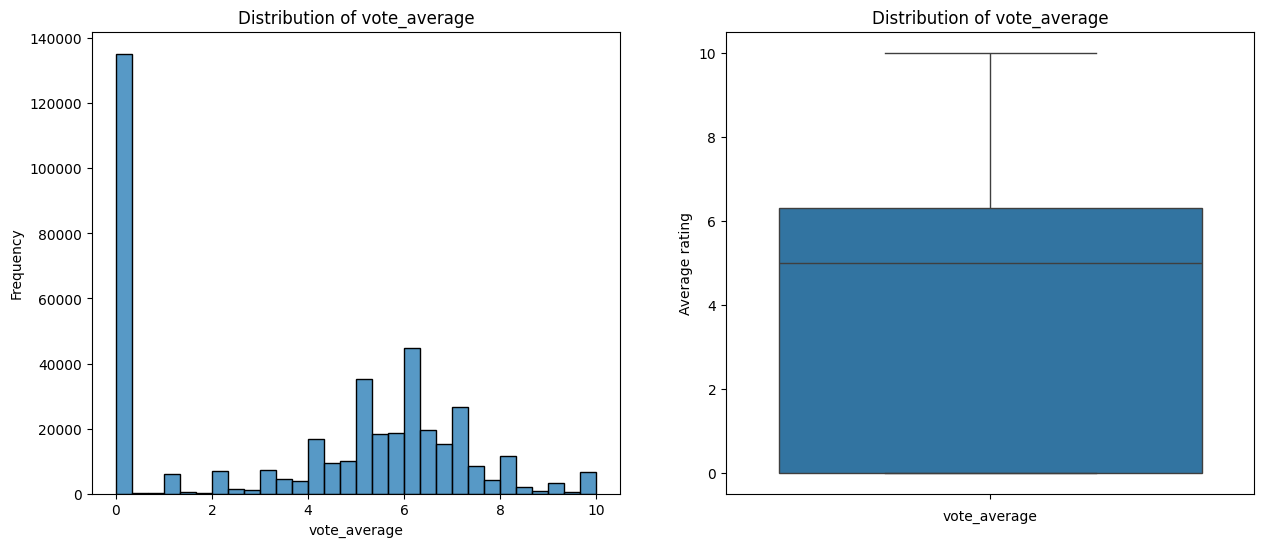

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df['vote_average'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_average')
ax[0].set_xlabel('vote_average')
ax[0].set_ylabel('Frequency')
sns.boxplot(df['vote_average'], ax=ax[1])
ax[1].set_title('Distribution of vote_average')
ax[1].set_xlabel('vote_average')
ax[1].set_ylabel('Average rating')
plt.show()

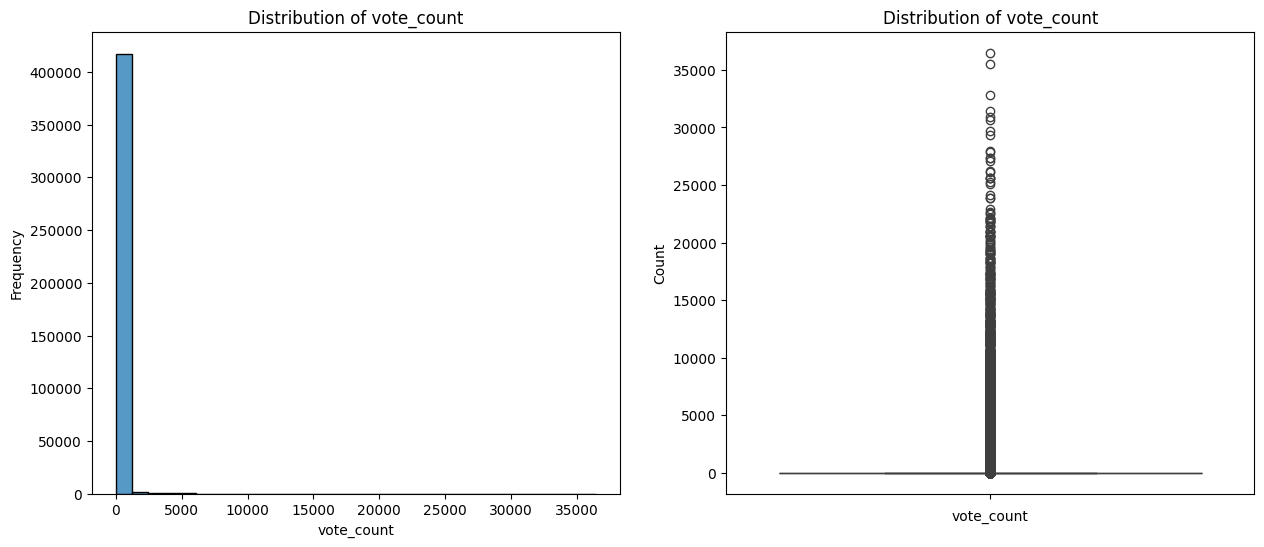

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df['vote_count'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_count')
ax[0].set_xlabel('vote_count')
ax[0].set_ylabel('Frequency')
sns.boxplot(df['vote_count'], ax=ax[1])
ax[1].set_title('Distribution of vote_count')
ax[1].set_xlabel('vote_count')
ax[1].set_ylabel('Count')
plt.show()

This is a highly skewed graph. It is not the result of any weird outliers, but the result of having too many movies with a every small number of vote_count and vote_average of zero.\
Let's see their distributions putting together.

Text(0.5, 1.0, 'Scatterplot of vote_average vs vote_count')

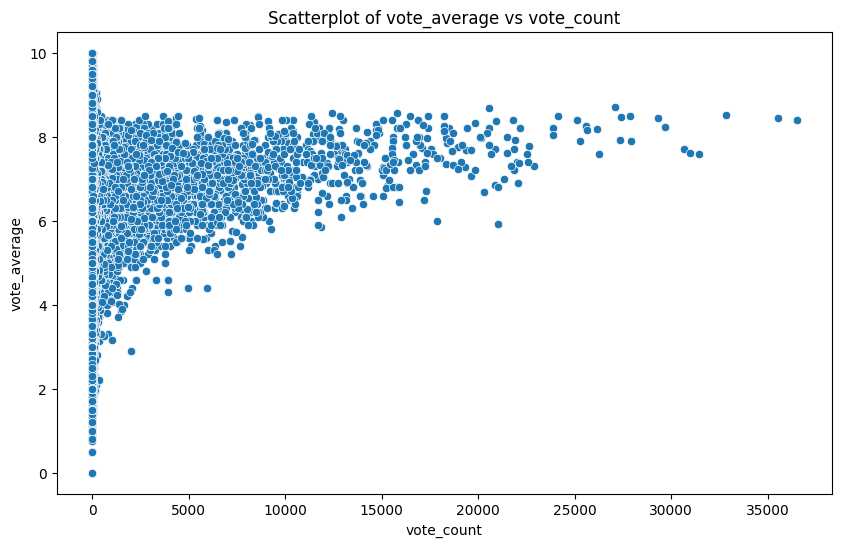

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vote_count', y='vote_average', data=df)
plt.title('Scatterplot of vote_average vs vote_count')

Now we will try to check the distribution without movies with zero votes.

In [16]:
vote_df = df[['vote_average', 'vote_count']]
rows_before = vote_df.shape[0]
vote_df = vote_df[vote_df['vote_count'] > 0]
rows_after = vote_df.shape[0]
print(f'Number of movies with zero votes: {rows_before - rows_after}')

Number of movies with zero votes: 135075


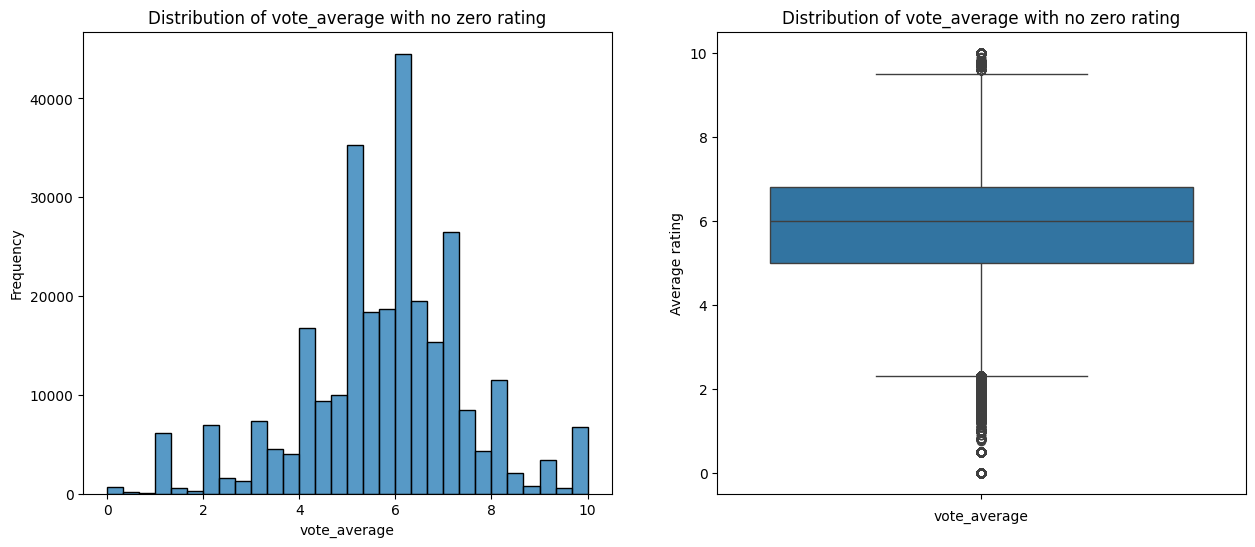

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(vote_df['vote_average'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_average with no zero rating')
ax[0].set_xlabel('vote_average')
ax[0].set_ylabel('Frequency')
sns.boxplot(vote_df['vote_average'], ax=ax[1])
ax[1].set_title('Distribution of vote_average with no zero rating')
ax[1].set_xlabel('vote_average')
ax[1].set_ylabel('Average rating')
plt.show()

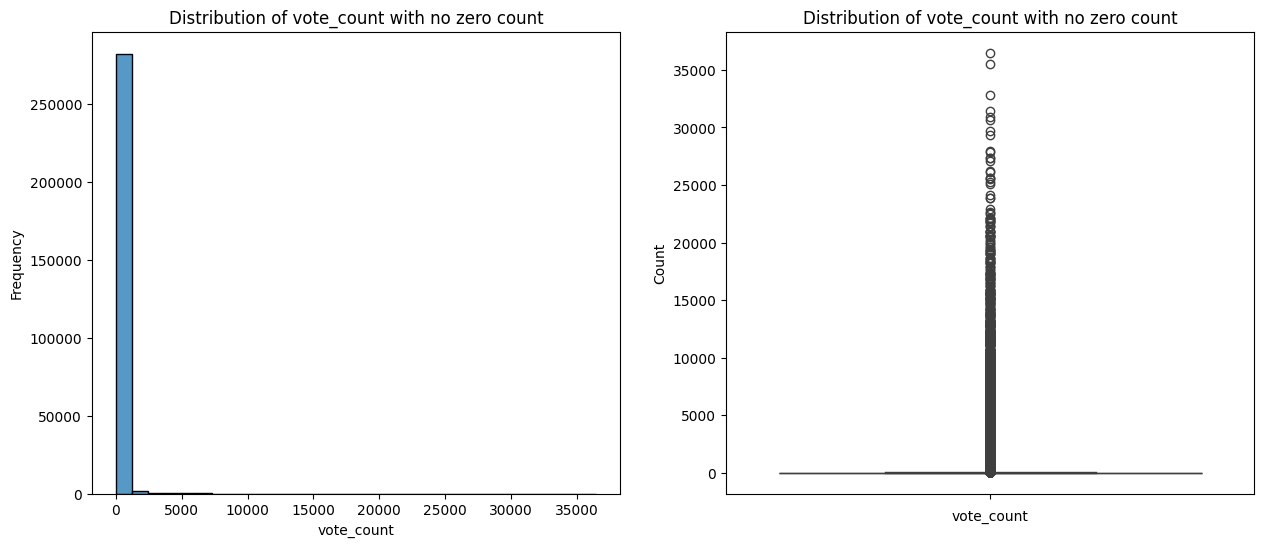

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(vote_df['vote_count'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_count with no zero count')
ax[0].set_xlabel('vote_count')
ax[0].set_ylabel('Frequency')
sns.boxplot(vote_df['vote_count'], ax=ax[1])
ax[1].set_title('Distribution of vote_count with no zero count')
ax[1].set_xlabel('vote_count')
ax[1].set_ylabel('Count')
plt.show()

The distribution of vote_count is still highly skewed since there is a lot of movies with only a small number of votes.

### Status

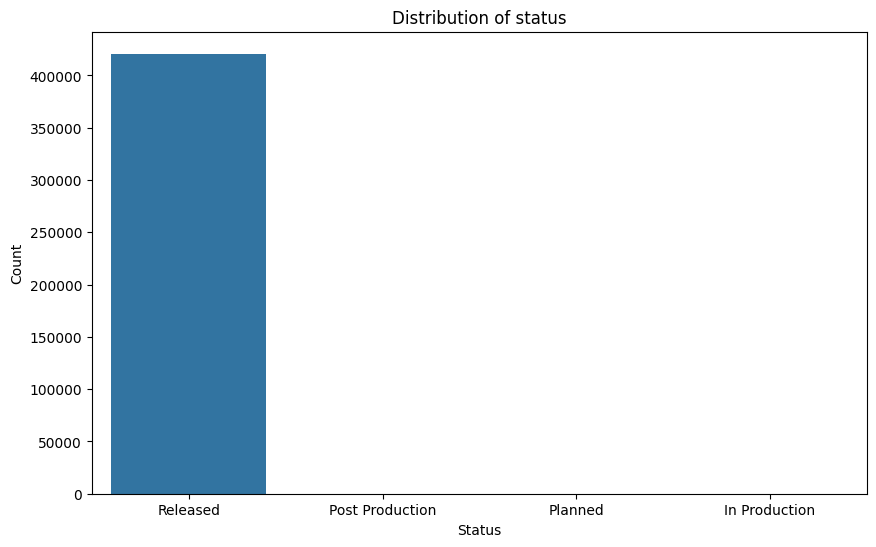

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['status'])
plt.title('Distribution of status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

In [20]:
df['status'].value_counts()

,count
status,
Released,420827
Post Production,33
In Production,14
Planned,5


## release_date

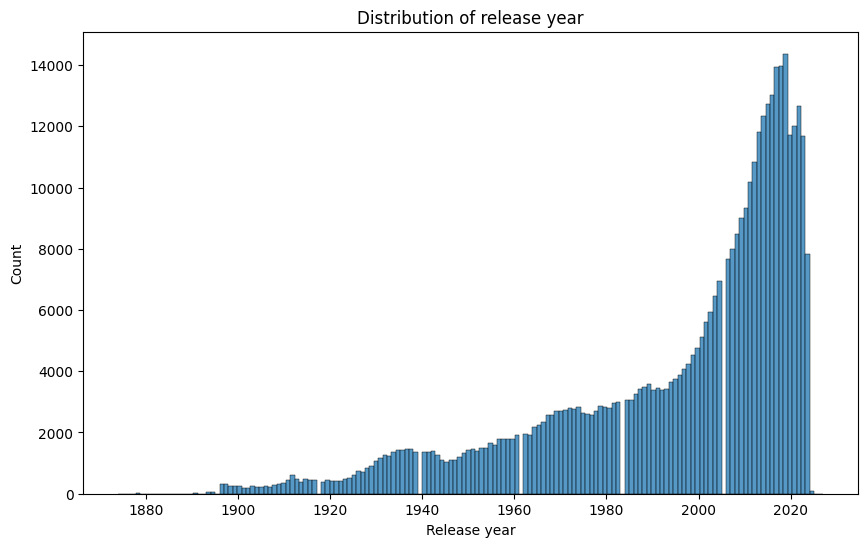

In [21]:
dates = pd.to_datetime(df['release_date'])
plt.figure(figsize=(10, 6))
sns.histplot(dates.dt.year)
plt.title('Distribution of release year')
plt.xlabel('Release year')
plt.ylabel('Count')
plt.show()

## revenue




In [22]:
df['revenue'].value_counts(ascending=False)

,count
revenue,
0.0,401856
100000.0,91
1000000.0,80
2000000.0,77
10000000.0,66
...,...
1919653.0,1
1845819.0,1
5835036.0,1


Since most of the movies does not have any revenue, it will be another skewed distribution. We will get rid of all the zeros and display the distribution of rest of the data.

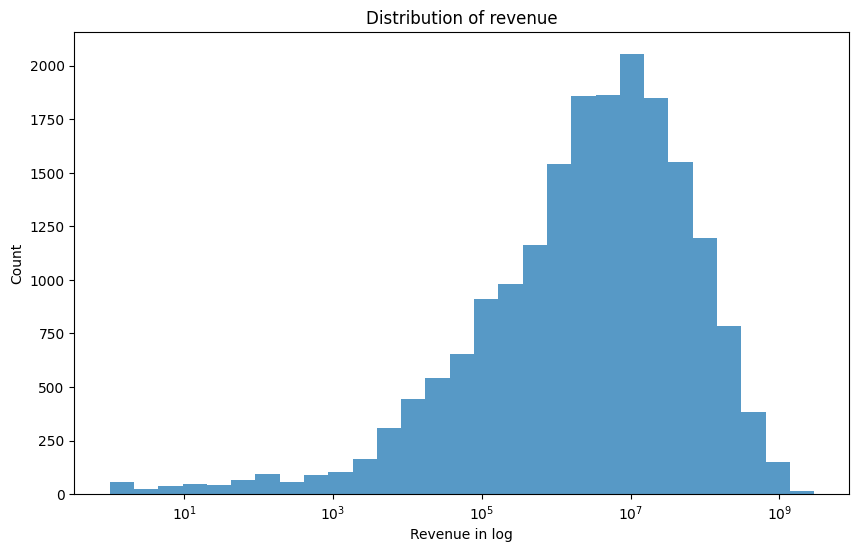

In [23]:
r = df[df['revenue']>0]['revenue']
min_val = r.min()
max_val = r.max()
bins = np.logspace(np.log10(min_val), np.log10(max_val), 30)

plt.figure(figsize=(10, 6))
sns.histplot(r, bins=bins)
plt.title('Distribution of revenue')
plt.xlabel('Revenue in log')
plt.ylabel('Count')
plt.xscale('log')
plt.show()

## Sampling & Train Test Split
### Random split

In [24]:
X_train, X_temp, y_train, y_temp = train_test_split(df.drop(columns=['imdb_rating']), df['imdb_rating'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f'Shape of the training set: {X_train.shape}')
print(f'Shape of the validation set: {X_val.shape}')
print(f'Shape of the test set: {X_test.shape}')

Shape of the training set: (336703, 23)
Shape of the validation set: (42088, 23)
Shape of the test set: (42088, 23)


### Stratified split

In [25]:
kbd = KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='quantile')
y_bin = kbd.fit_transform(df[['imdb_rating']])
X_train_str, X_temp_str, y_train_str, y_temp_str = train_test_split(df.drop(columns=['imdb_rating']), df['imdb_rating'], test_size=0.2, random_state=42, stratify=y_bin)
y_temp_str = pd.DataFrame(y_temp_str, columns=['imdb_rating'])
y_test_bin = kbd.transform(y_temp_str)
X_val_str, X_test_str, y_val_str, y_test_str = train_test_split(X_temp_str, y_temp_str, test_size=0.5, random_state=42, stratify=y_test_bin)
print(f'Shape of the training set: {X_train_str.shape}')
print(f'Shape of the validation set: {X_val_str.shape}')
print(f'Shape of the test set: {X_test_str.shape}')

Shape of the training set: (336703, 23)
Shape of the validation set: (42088, 23)
Shape of the test set: (42088, 23)


## Encoding

In [26]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print(df.head())

                              title  vote_average  vote_count    status  \
0                             Ariel      1.057565    0.496403  Released   
1               Shadows in Paradise      1.123579    0.556916  Released   
2                        Four Rooms      0.628477    4.568549  Released   
3                    Judgment Night      0.859525    0.489284  Released   
4  Life in Loops (A Megacities RMX)      1.189593   -0.051770  Released   

  release_date   revenue   runtime    budget original_language  \
0   1988-10-21 -0.066906  0.072079 -0.095732                fi   
1   1986-10-17 -0.066906  0.088067 -0.095732                fi   
2   1995-12-09  0.091338  0.471778  0.456426                en   
3   1993-10-15  0.384219  0.647645  2.803097                en   
4   2006-01-01 -0.066906  0.183995 -0.089935                en   

                     original_title  ...      production_countries  \
0                             Ariel  ...                   Finland   
1           

In [27]:
categorical_vars = df.select_dtypes(include=['object', 'category']).columns
print("Categorical variables in the DataFrame:")
print(categorical_vars)

Categorical variables in the DataFrame:
Index(['title', 'status', 'release_date', 'original_language',
       'original_title', 'tagline', 'genres', 'production_companies',
       'production_countries', 'spoken_languages', 'cast', 'director',
       'director_of_photography', 'writers', 'producers', 'music_composer'],
      dtype='object')


In [28]:
finite_categories = ['status', 'original_language', 'genres', 'production_companies', 'production_countries', 'spoken_languages']
for col in finite_categories:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())


Column: status
Unique values: ['Released' 'Post Production' 'Planned' 'In Production']

Column: original_language
Unique values: ['fi' 'en' 'de' 'he' 'es' 'zh' 'ja' 'da' 'fr' 'ko' 'pl' 'sv' 'it' 'bs'
 'hi' 'ru' 'no' 'pt' 'nl' 'el' 'cs' 'bn' 'cn' 'tn' 'sr' 'mn' 'et' 'is'
 'ca' 'ro' 'hu' 'se' 'ps' 'th' 'xx' 'tr' 'sh' 'fa' 'ht' 'bg' 'zu' 'ar'
 'mr' 'ku' 'bo' 'ta' 'tl' 'kk' 'hr' 'id' 'am' 'lt' 'iu' 'pa' 'te' 'sl'
 'vi' 'ml' 'mk' 'sk' 'af' 'ur' 'km' 'nb' 'ms' 'hy' 'uk' 'ka' 'la' 'kn'
 'dz' 'ga' 'eu' 'bm' 'sq' 'gl' 'mo' 'si' 'rw' 'ky' 'eo' 'xh' 'az' 'jv'
 'tg' 'ff' 'lv' 'oc' 'wo' 'ik' 'uz' 'lo' 'ks' 'sm' 'gd' 'cy' 'ln' 'sn'
 'yi' 'tk' 'ab' 'mt' 'sw' 'kl' 'ne' 'fo' 'so' 've' 'lb' 'sa' 'co' 'yo'
 'fy' 'gu' 'sc' 'ig' 'ay' 'mg' 'gn' 'qu' 'cr' 'cv' 'mh' 'mi' 'my' 'to'
 'dv' 'tw' 'or' 'st' 'li' 'as' 'ha' 'ug' 'ak' 'nn' 'be' 'ti' 'ny' 'ty'
 'ss' 'om' 'tt' 'ce' 'rm' 'os' 'nv' 'gv' 'sd' 'lg' 'ba' 'su' 'kg' 'kw'
 'nd' 'sg']

Column: genres
Unique values: ['Comedy, Drama, Romance, Crime' 'Comedy, Dram

In [29]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
status_encoded = one_hot_encoder.fit_transform(df[['status']])

status_encoded_df = pd.DataFrame(status_encoded, columns=one_hot_encoder.get_feature_names_out(['status']), index=df.index)
df = pd.concat([df, status_encoded_df], axis=1)

target_encode_cols = ['original_language', 'production_companies', 'production_countries', 'spoken_languages', 'genres']

target_col = 'imdb_rating'

for col in target_encode_cols:
    target_mean = df.groupby(col)[target_col].mean()
    df[f"{col}_target_encoded"] = df[col].map(target_mean)

df.drop(columns=target_encode_cols, inplace=True)

print(df.head())



                              title  vote_average  vote_count    status  \
0                             Ariel      1.057565    0.496403  Released   
1               Shadows in Paradise      1.123579    0.556916  Released   
2                        Four Rooms      0.628477    4.568549  Released   
3                    Judgment Night      0.859525    0.489284  Released   
4  Life in Loops (A Megacities RMX)      1.189593   -0.051770  Released   

  release_date   revenue   runtime    budget  \
0   1988-10-21 -0.066906  0.072079 -0.095732   
1   1986-10-17 -0.066906  0.088067 -0.095732   
2   1995-12-09  0.091338  0.471778  0.456426   
3   1993-10-15  0.384219  0.647645  2.803097   
4   2006-01-01 -0.066906  0.183995 -0.089935   

                     original_title  popularity  ... imdb_rating imdb_votes  \
0                             Ariel    0.558098  ...    0.885384   0.185339   
1              Varjoja paratiisissa    0.840113  ...    0.961638   0.146244   
2                      

## Dimension Reduction:

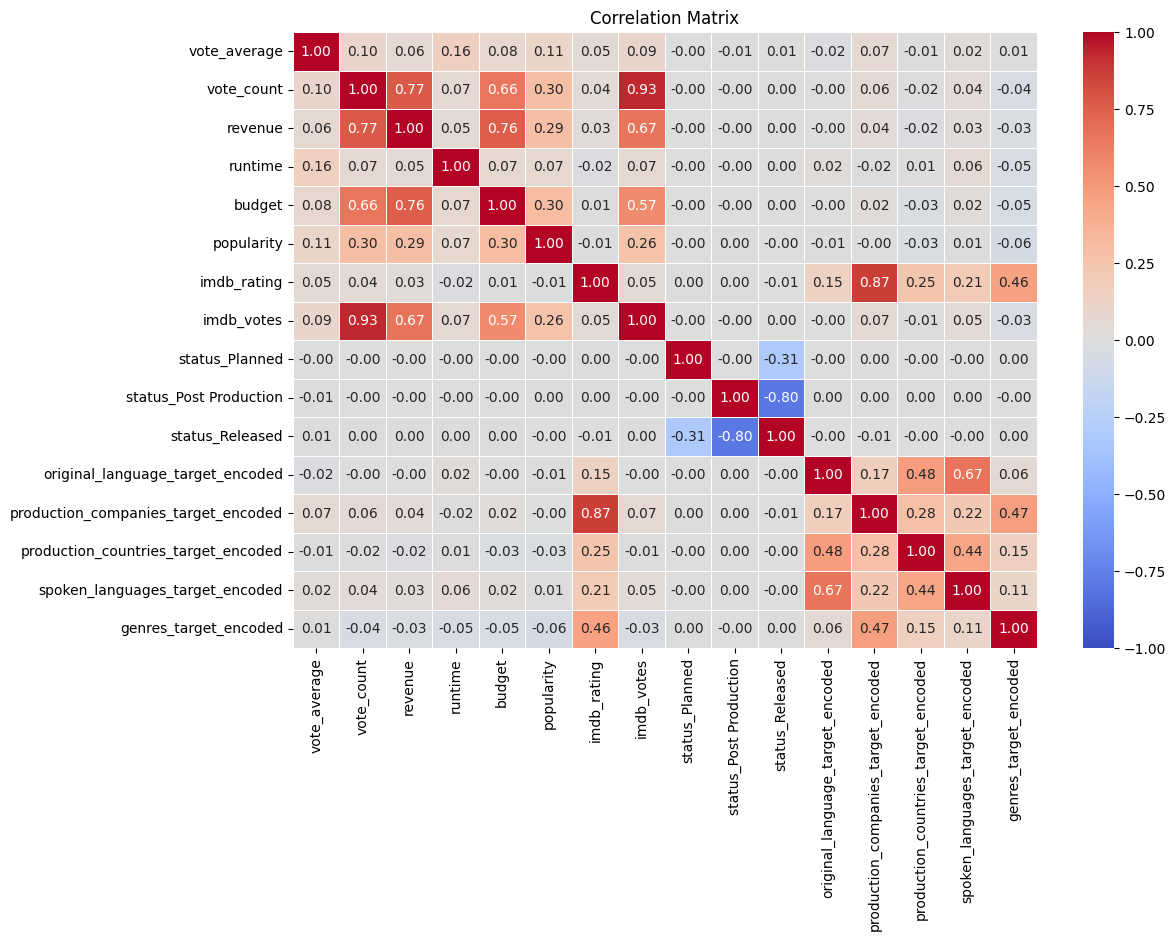

Dropped columns: {'production_companies_target_encoded', 'imdb_votes'}
                              title  vote_average  vote_count    status  \
0                             Ariel      1.057565    0.496403  Released   
1               Shadows in Paradise      1.123579    0.556916  Released   
2                        Four Rooms      0.628477    4.568549  Released   
3                    Judgment Night      0.859525    0.489284  Released   
4  Life in Loops (A Megacities RMX)      1.189593   -0.051770  Released   

  release_date   revenue   runtime    budget  \
0   1988-10-21 -0.066906  0.072079 -0.095732   
1   1986-10-17 -0.066906  0.088067 -0.095732   
2   1995-12-09  0.091338  0.471778  0.456426   
3   1993-10-15  0.384219  0.647645  2.803097   
4   2006-01-01 -0.066906  0.183995 -0.089935   

                     original_title  popularity  ...  \
0                             Ariel    0.558098  ...   
1              Varjoja paratiisissa    0.840113  ...   
2                    

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df_numerical = df[numerical_cols]
correlation_matrix = df_numerical.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


cols_to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            cols_to_drop.add(colname)

df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped columns: {cols_to_drop}")
print(df.head())


## Handling release_date and original_title

In [31]:
df['original_title_match'] = df['original_title'] == df['title']
df.drop(columns=['original_title'], inplace=True)

In [32]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year

def get_decade(year):
    if pd.isna(year):
        return None
    return f"{(year // 10) * 10}s"

df['decade'] = df['release_year'].apply(get_decade)
df_decade_dummies = pd.get_dummies(df['decade'], prefix='decade')
df = pd.concat([df, df_decade_dummies], axis=1)


print(df.head())


                              title  vote_average  vote_count    status  \
0                             Ariel      1.057565    0.496403  Released   
1               Shadows in Paradise      1.123579    0.556916  Released   
2                        Four Rooms      0.628477    4.568549  Released   
3                    Judgment Night      0.859525    0.489284  Released   
4  Life in Loops (A Megacities RMX)      1.189593   -0.051770  Released   

  release_date   revenue   runtime    budget  popularity  \
0   1988-10-21 -0.066906  0.072079 -0.095732    0.558098   
1   1986-10-17 -0.066906  0.088067 -0.095732    0.840113   
2   1995-12-09  0.091338  0.471778  0.456426    0.955706   
3   1993-10-15  0.384219  0.647645  2.803097    0.365164   
4   2006-01-01 -0.066906  0.183995 -0.089935   -0.003869   

                                             tagline  ... decade_1930s  \
0                                                NaN  ...        False   
1                                       

## Text Vectorization (RAM issue)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorize_cols = ['title', 'tagline', 'cast', 'director',
                  'director_of_photography', 'writers',
                  'producers', 'music_composer']

# vectorize_cols = ['title']

vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

for col in tqdm(vectorize_cols):
    df[col] = df[col].fillna('')
    df[col] = df[col].apply(lambda x: ' '.join([name.strip().replace(' ', '_') for name in x.split(',')]))


    tfidf_matrix = vectorizer.fit_transform(df[col])

    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

    df = pd.concat([df, tfidf_df], axis=1)

print(df.head())


100%|██████████| 8/8 [00:45<00:00,  5.69s/it]

                              title  vote_average  vote_count    status  \
0                             Ariel      1.057565    0.496403  Released   
1               Shadows_in_Paradise      1.123579    0.556916  Released   
2                        Four_Rooms      0.628477    4.568549  Released   
3                    Judgment_Night      0.859525    0.489284  Released   
4  Life_in_Loops_(A_Megacities_RMX)      1.189593   -0.051770  Released   

  release_date   revenue   runtime    budget  popularity  \
0   1988-10-21 -0.066906  0.072079 -0.095732    0.558098   
1   1986-10-17 -0.066906  0.088067 -0.095732    0.840113   
2   1995-12-09  0.091338  0.471778  0.456426    0.955706   
3   1993-10-15  0.384219  0.647645  2.803097    0.365164   
4   2006-01-01 -0.066906  0.183995 -0.089935   -0.003869   

                                             tagline  ... stelvio_cipriani  \
0                                                     ...              0.0   
1                               

In [34]:
print(df.shape)

(420879, 843)


In [35]:
print(df.head())

                              title  vote_average  vote_count    status  \
0                             Ariel      1.057565    0.496403  Released   
1               Shadows_in_Paradise      1.123579    0.556916  Released   
2                        Four_Rooms      0.628477    4.568549  Released   
3                    Judgment_Night      0.859525    0.489284  Released   
4  Life_in_Loops_(A_Megacities_RMX)      1.189593   -0.051770  Released   

  release_date   revenue   runtime    budget  popularity  \
0   1988-10-21 -0.066906  0.072079 -0.095732    0.558098   
1   1986-10-17 -0.066906  0.088067 -0.095732    0.840113   
2   1995-12-09  0.091338  0.471778  0.456426    0.955706   
3   1993-10-15  0.384219  0.647645  2.803097    0.365164   
4   2006-01-01 -0.066906  0.183995 -0.089935   -0.003869   

                                             tagline  ... stelvio_cipriani  \
0                                                     ...              0.0   
1                               

In [36]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# import pandas as pd

# # vectorize_cols = ['title', 'original_title', 'tagline', 'cast', 'director',
# #                   'director_of_photography', 'writers',
# #                   'producers', 'music_composer']

# vectorize_cols = ['title', 'tagline',]

# vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

# for col in vectorize_cols:
#     df[col] = df[col].fillna('')

#     tfidf_matrix = vectorizer.fit_transform(df[col])

#     tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

#     df = pd.concat([df, tfidf_df], axis=1)

# print(df.head())


In [37]:
df.columns

Index(['title', 'vote_average', 'vote_count', 'status', 'release_date',
       'revenue', 'runtime', 'budget', 'popularity', 'tagline',
       ...
       'stelvio_cipriani', 'thomas_newman', 'victor_young', 'vladimir_cosma',
       'wang_fu', 'william_lava', 'williams', 'winston_sharples',
       'yuvan_shankar_raja', 'zdeněk_liška'],
      dtype='object', length=843)